Urgent action items (Thursday):

# Data Prep

## Abstract
How do humans and other primates perceive daily objects of various features and categorize these seemingly intuitive and effortless mental representations? Prior literature has mainly focused on investigating this question by applying supervised machine learning classifiers to neural responses recorded from tasks in which humans (and monkeys) were asked to view  images of isolated objects (Kriegeskorte et al., 2008; Kiani et al., 2007). These classifiers have demonstrated that neurons in the inferior temporal (IT) cortex distinguish objects through a system of hierarchical categories that is consistent with the experimenter's predefined structure (superordinate, ordinate, subordinate). However, it remains elusive whether the spatio-temporal patterns of BOLD activations are entirely a reflection of these hierarchical categories or if they can also be accounted for by other attributes of these images such as low level image features, sentiment, and familiarity. Therefore, we hope to investigate whether other attributes may have confounded the prior results by computing RDMs of other features of these images, such as lower-level visual attributes, sentiment and familiarity and use them as predictors of the neural RDMs computed in IT regions (fMRI). Behavioural data was collected from voluntary participants (n = 33) with a survey deployed online by evaluating the sentiment and familiarity of the 92 images in the original study. Low level features of the images were extracted using a pre-trained convolutional network model (AlexNet) to compute activation maps for each image. Simple regression models were built in conjunction with a variance partitioning analysis to parsimoniously examine the contribution of new attributes of interest to the neural responses in the IT region, and test whether the initial hierarchical structure of categories remains true after regressing out the influence of these possible confounds. 



## Project Summary
We are interested in investigating the hierarchical structure of processing object categorization in the human brain. More specifically we hope to investigate the correlation between the RDMs computed based on fMRI neuroimaging dataset from Cichy et al.,2014[1] and the RDMs of other attributes of the 92 images they presented to subjects, such as visual attributes and sentiment. 

The original dataset from Cichy et al. 2014 consists of fMRI responses from early visual cortex (EVC) and inferior temporal (IT) cortex and MEG responses at different timepoints in the form of representational dissimilarity matrices (RDMs) to 92 images. However, we are only intersted in the spacial representations of these 92 images, so we will be only using the fMRI dataset. 

We will be relying heavily on a method called 



## Representational Similarity Analysis (RSA)
RSA is a method to relate signals
from different source spaces (such as behavior, neural
responses, DNN activations) by abstracting signals from
separate source spaces into a common similarity space. For
this, in each source space, condition-specific responses are
compared to each other for dissimilarity (e.g., by calculating
Euclidean distances between signals), and the values are
aggregated in so-called representational dissimilarity matrices (RDMs) indexed in rows and columns by the conditions
compared. RDMs thus summarize the representational
geometry of the source space signals. Different from source
space signals themselves, RDMs from different sources
spaces are directly comparable to each other for similarity
and thus can relate signals from different spaces 

The figure below illustrates how RSA can be applied to different problems by comparing RDMs of different modalities/species.

## Load data from Cichy et al. 2014

In the cells below, we will download and visualize MEG and fMRI RDMs. Please refer Figure 1 in [1] to learn details about the image category order in RDMs 

In [2]:
#check library availability
import importlib
required_libraries = ['nibabel', 'cv2', 'glob', 'argparse', 
                      'torchvision', 'pickle', 'torch', "plotly"]
                      
for lib in required_libraries:
    if importlib.util.find_spec(lib) is None:
        print("%s unavailable" % lib)

nibabel unavailable
cv2 unavailable


In [11]:
# run installs 
#!pip install torch
#!pip install nibabel
#!pip install opencv-python
#!apt update && apt install ffmpeg libsm6 libxext6  -y
#!pip install plotly
!pip install researchpy

     |████████████████████████████████| 231 kB 29.8 MB/s 
     |████████████████████████████████| 9.5 MB 30.6 MB/s 


### Load packages

In [ ]:
#!pip install opencv-python==4.5.3.56

In [12]:
#@title Imports
import glob
import pandas as pd
import numpy as np
import torch
import cv2
import argparse
import time
import random
import torchvision
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from tqdm import tqdm
from PIL import Image
from torchvision import transforms as trn
import scipy.io as sio
from scipy.stats import zscore
import h5py
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import plotly.express as px
import matplotlib.image as img
import plotly.graph_objects as go




def loadmat(matfile):
    """Function to load .mat files.
    Parameters
    ----------
    matfile : str
        path to `matfile` containing fMRI data for a given trial.
    Returns
    -------
    dict
        dictionary containing data in key 'vol' for a given trial.
    """
    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return sio.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

### Download data 

In [13]:
##@title Data download
!wget -qO data.zip -c https://osf.io/7vpyh/download

#%%capture
!unzip -o data.zip #unzip the files

Archive:  data.zip
  inflating: 92_Image_Set/ReadMe_92ImageSet.docx  
  inflating: 92_Image_Set/92images/image_62.jpg  
  inflating: 92_Image_Set/92images/image_74.jpg  
  inflating: 92_Image_Set/92images/image_79.jpg  
  inflating: 92_Image_Set/92images/image_73.jpg  
  inflating: 92_Image_Set/92images/image_86.jpg  
  inflating: 92_Image_Set/92images/image_92.jpg  
  inflating: 92_Image_Set/92images/image_89.jpg  
  inflating: 92_Image_Set/92images/image_90.jpg  
  inflating: 92_Image_Set/92images/image_63.jpg  
  inflating: 92_Image_Set/92images/image_82.jpg  
  inflating: 92_Image_Set/92images/image_81.jpg  
  inflating: 92_Image_Set/92images/image_91.jpg  
  inflating: 92_Image_Set/92images/image_87.jpg  
  inflating: 92_Image_Set/92images/image_77.jpg  
  inflating: 92_Image_Set/92images/image_88.jpg  
  inflating: 92_Image_Set/92images/image_64.jpg  
  inflating: 92_Image_Set/92images/image_80.jpg  
  inflating: 92_Image_Set/92images/image_72.jpg  
  inflating: 92_Image_Set/92im

# Data Visualization

## Exploring stimuli (92 images)

In [14]:
# load one image 
folder_imgs = "/work/Stimuli/92images" # set path to folder with images
test_img = '/work/Stimuli/92images/image_01.jpg'

In [15]:
# get shape of one image
with Image.open(test_img) as image:
    width, height = image.size

In [16]:
# print shape of image (n_pix * n_pix)
print ("Shape is {}, {}".format(width,height))

Shape is 175, 175


In [17]:
# get the paths to all the images in the stimulus set

image_list = glob.glob(folder_imgs + '/*.jpg')
image_list.sort()
print('Total Number of Images: ', len(image_list))
print(image_list[1])

Total Number of Images:  92
/work/Stimuli/92images/image_02.jpg


In [18]:
# loop over images and make into numpy array

image_array = []
filenames = []
foldername = "./92_Image_Set/92images"


for filename in image_list:

    filenames.append(filename)
    #filenames.sort()
    image = img.imread(filename)
    
    # stack images into one array
    image_array.append(image)


image_array = np.array(image_array)
filenames = np.array(filenames)

In [19]:
def plot_image(img):
  """
  Plot a single image.
  
  Args:
     img: image to be plotted.
     
  """
  plt.imshow(img)
  plt.show()

  
def plot_grid_images(image_array, n):  
  """
  Randomly sample n images from an image set and plot them in a grid.
  
  Args:
     imgs: collection of images from which sampling will be made.
     n: the number of images to be sampled.
     
  """
  sampled_images = image_array
  
  sampled_images = np.transpose(sampled_images, (0, 3, 1, 2))
  sampled_tensor = torch.Tensor(sampled_images)
  
  grid_tensor = torchvision.utils.make_grid(
      sampled_tensor, normalize=True, value_range=(0, 255)
  )
  grid_tensor = np.transpose(grid_tensor.numpy(), (1, 2, 0))
  
  plot_image(grid_tensor)

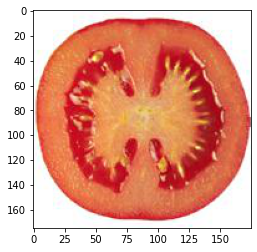

In [20]:
# we can now use indexes to plot images
plot_image(image_array[63])  # where 0 can be changed be any index [0,92]

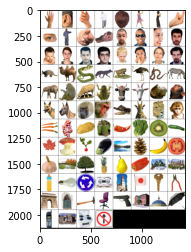

In [21]:
plot_grid_images(image_array, 92)

##### Shape of stimuli `n_pictures` x `n_pixels` * `n_pixels` x `n_channels (R,G,B)`

###### 92 x 175 x 175 x 3

## Exploring behavioral data

In [22]:
# path to sentiment data
path_sent = "/work/Behavioral_Dat_RLanguage/sentimentOutput.csv"
df_sent = pd.read_csv(path_sent, sep = ",").drop(columns = "Unnamed: 0")

df_sent.head()

,image,rating,Label
0,image_01,0.0,Human_Body
1,image_01,2.0,Human_Body
2,image_01,0.0,Human_Body
3,image_01,1.0,Human_Body
4,image_01,0.0,Human_Body


In [23]:
# path to familiarity data
path_fam = "/work/Behavioral_Dat_RLanguage/familiarityOutput.csv"
df_familiarity = pd.read_csv(path_fam, sep = ",").drop(columns = "Unnamed: 0")

df_familiarity.head()

,image,rating,Label
0,image_01,5.0,Human_Body
1,image_01,5.0,Human_Body
2,image_01,3.0,Human_Body
3,image_01,3.0,Human_Body
4,image_01,5.0,Human_Body


In [24]:
# get categories
labels = df_sent.Label.unique()

In [25]:
# count plot  for each category of images for sentiment data
import plotly
fig = go.Figure()

for i, label in zip (range(len(labels)), labels):
    fig.add_trace(go.Histogram(x=df_sent[df_sent.Label == labels[i]].rating, name=label, histnorm='probability density'))

fig.update_layout(
    title="Distribution of scores for sentiment associated with images",
    font_family="Courier New",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="red",
    legend_title_font_color="green")

fig.show()

In [26]:
# count plot  for each category of images for familiarity data
import plotly
fig = go.Figure()

for i, label in zip (range(len(labels)), labels):
    fig.add_trace(go.Histogram(x=df_familiarity[df_familiarity.Label == labels[i]].rating, name=label, histnorm='probability density'))

fig.update_layout(
    title="Distribution of scores for familiarity associated with images",
    font_family="Courier New",
    font_color="black",
    title_font_family="Times New Roman",
    title_font_color="red",
    legend_title_font_color="green")

fig.show()

In [ ]:
df_sent.Label.value_counts()

Natural          759
Artificial       693
Nonhuman_Body    396
Human_Body       396
Nonhuman_Face    396
Human_Face       396
Name: Label, dtype: int64

In [ ]:
list_image_names = ["image_{}".format(i) for i in range(92 + 1)]
print(list_image_names)

['image_0', 'image_1', 'image_2', 'image_3', 'image_4', 'image_5', 'image_6', 'image_7', 'image_8', 'image_9', 'image_10', 'image_11', 'image_12', 'image_13', 'image_14', 'image_15', 'image_16', 'image_17', 'image_18', 'image_19', 'image_20', 'image_21', 'image_22', 'image_23', 'image_24', 'image_25', 'image_26', 'image_27', 'image_28', 'image_29', 'image_30', 'image_31', 'image_32', 'image_33', 'image_34', 'image_35', 'image_36', 'image_37', 'image_38', 'image_39', 'image_40', 'image_41', 'image_42', 'image_43', 'image_44', 'image_45', 'image_46', 'image_47', 'image_48', 'image_49', 'image_50', 'image_51', 'image_52', 'image_53', 'image_54', 'image_55', 'image_56', 'image_57', 'image_58', 'image_59', 'image_60', 'image_61', 'image_62', 'image_63', 'image_64', 'image_65', 'image_66', 'image_67', 'image_68', 'image_69', 'image_70', 'image_71', 'image_72', 'image_73', 'image_74', 'image_75', 'image_76', 'image_77', 'image_78', 'image_79', 'image_80', 'image_81', 'image_82', 'image_83', '

In [ ]:
# countplot for individual images

def plot_countplot(image_n):
    fig_img = go.Figure()
    
    # Add Traces
    fig_img.add_trace(
        go.Histogram(x=df_sent[df_sent.image == image_n].rating, name=image_n))
    
    return fig_img

In [ ]:
plot_countplot("image_01")

In [27]:
def stats_bycategory(dataframe, describe = "all"):
    if describe == "all":
        
        for label in labels:
            
            print("--------------- statistics CATEGORY {} ------------------- ".format(label))
            print(dataframe.loc[dataframe.Label == label].describe())
    else :
        print("--------------- statistics CATEGORY {} ------------------- ".format(describe))
        print (daataframe.loc[dataframe_sent.Label == describe].describe())

    return


In [28]:
stats_bycategory(df_sent, describe = "all")

--------------- statistics CATEGORY Human_Body ------------------- 
           rating
count  386.000000
mean     0.064767
std      0.884764
min     -2.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      2.000000
--------------- statistics CATEGORY Human_Face ------------------- 
           rating
count  386.000000
mean     0.051813
std      0.921551
min     -2.000000
25%     -1.000000
50%      0.000000
75%      1.000000
max      2.000000
--------------- statistics CATEGORY Nonhuman_Body ------------------- 
           rating
count  388.000000
mean     0.069588
std      0.949801
min     -2.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      2.000000
--------------- statistics CATEGORY Nonhuman_Face ------------------- 
           rating
count  388.000000
mean     0.195876
std      0.947066
min     -2.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      2.000000
--------------- statistics CATEGORY Natural ------------------- 
         

In [29]:
stats_bycategory(df_familiarity, describe = "all")

--------------- statistics CATEGORY Human_Body ------------------- 
           rating
count  386.000000
mean     3.795337
std      1.133701
min      1.000000
25%      3.000000
50%      4.000000
75%      5.000000
max      5.000000
--------------- statistics CATEGORY Human_Face ------------------- 
           rating
count  385.000000
mean     3.483117
std      1.181608
min      1.000000
25%      3.000000
50%      3.000000
75%      5.000000
max      5.000000
--------------- statistics CATEGORY Nonhuman_Body ------------------- 
           rating
count  388.000000
mean     2.518041
std      1.206007
min      1.000000
25%      2.000000
50%      2.000000
75%      3.000000
max      5.000000
--------------- statistics CATEGORY Nonhuman_Face ------------------- 
           rating
count  387.000000
mean     2.868217
std      1.255330
min      1.000000
25%      2.000000
50%      3.000000
75%      4.000000
max      5.000000
--------------- statistics CATEGORY Natural ------------------- 
         

In [30]:

#labels = ["hand", "ear", "hand", 'chef', "hair", "women_6", "women_7", "finger", "eye"
#"suit", "pointing", "fist", "face", "face", "face", "face", "face", "face", "face", "face"
#"face", "face", "face", "face", "_", "camel", "snake", "wolve", "monkey", "austria", "snake"
#"zebra", "elephant", "monkey", "goat", "frog", "cow", "goat", "monkey", "monkey", "dog", "dog",
#"gorilla", "monkey", "snake_","giraffe", "lion", "monkey", "carrots", "grapes", "potato", "shrub",
#"chilli", "lettuce", "kiwi", "squash", "leaf","apple", "radish", "eggplant", "lake", "cocottes_", 
#"banana", "tomato", "onion", "_", "tree", "pineaple", "pear", "pepper", "scenery", "scenery",
#"bottle", "bulb_", "symbol_recycling_", "tape", "church_", "flag", "key", "pliers_", "_", "_",
#"hammer", "chair", "gun", "building", "_", "umbrella", "phone", "house", "oven", "sign_"] 


In [31]:
def plot_dataset_histogram(labels, title='Label distribution', rel_freq=False):
  """
  Plot the histogram/distribution of the labels within a dataset.
  
  Args:
     labels: collection of labels from which the distribution is computed.
     title: the title of the histogram.
     rel_freq: if true, the histogram is normalized to show relative frequencies
               otherwise, it shows the frequencies.
     
  """
  _ = plt.hist(labels, bins=np.arange(11)-0.5, rwidth=0.85, density=rel_freq)
  plt.title(title)
  plt.xlabel('Label')
  if rel_freq:
    plt.ylabel('Relative frequency')
  else:
    plt.ylabel('Frequency')
  plt.xticks(np.arange(10))
  plt.show()

## Generating feature maps of Alexnet layer 1 (pending) 

In [32]:
# @title Plotting Functions

def show_stimulus(img, ax=None):
  """Visualize a stimulus"""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img+0.5, cmap=mpl.cm.binary)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

def plot_weights(weights, channels=[0], colorbar=True):
  """ plot convolutional channel weights
  Args:
        weights: weights of convolutional filters (conv_channels x K x K)
        channels: which conv channels to plot
  """
  wmax = torch.abs(weights).max()
  fig, axs = plt.subplots(1,len(channels), figsize=(12,2.5))
  for i, channel in enumerate(channels):
    im = axs[i].imshow(weights[channel,0], vmin=-wmax, vmax=wmax, cmap='bwr')
    axs[i].set_title('channel %d'%channel)

  if colorbar:
    ax = fig.add_axes([1, 0.1, 0.05, 0.8])
    plt.colorbar(im, ax=ax)
    ax.axis('off')

def plot_example_activations(stimuli, act, channels=[0]):
  """ plot activations act and corresponding stimulus
  Args:
        stimuli: stimulus input to convolutional layer (n x h x w) or (h x w)
        act: activations of convolutional layer (n_bins x conv_channels x n_bins)
        channels: which conv channels to plot
  """
  if stimuli.ndim>2:
    n_stimuli = stimuli.shape[0]
  else:
    stimuli = stimuli.unsqueeze(0)
    n_stimuli = 1

  fig, axs = plt.subplots(n_stimuli,1+len(channels),figsize=(12,12))

  # plot stimulus
  for i in range(n_stimuli):
    show_stimulus(stimuli[i].squeeze(), ax=axs[i, 0])
    axs[i, 0].set_title('stimulus')

    # plot example activations
    for k, (channel, ax) in enumerate(zip(channels, axs[i][1:])):
      img=ax.imshow(act[i,channel], vmin=-3, vmax=3, cmap='bwr')
      ax.set_xlabel('x-pos')
      ax.set_ylabel('y-pos')
      ax.set_title('channel %d'%channel)
  ax = fig.add_axes([1.05,0.8,0.01,0.1])
  plt.colorbar(img, cax=ax)
  ax.set_title('activation\n strength')


In [ ]:
## some experimentations
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD


in_channels = 1 # how many input channels in our images
h = 224 # height of images
w = 224 # width of images

#model = Net() ##model initializati
# Convolution layer parameters
K = 11 # filter size
out_channels = 64 # how many convolutional channels to have in our layer
#example_filters = filters(out_channels, K) # create filters to use

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(c_in=in_channels, 
            c_out=out_channels, K=K,stride=1, padding=1 ),
            #Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10) 
        ) 

In [ ]:
import torchvision.transforms as transforms

transforms.Compose([
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ])

Compose(
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
# Data augmentation

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
        # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

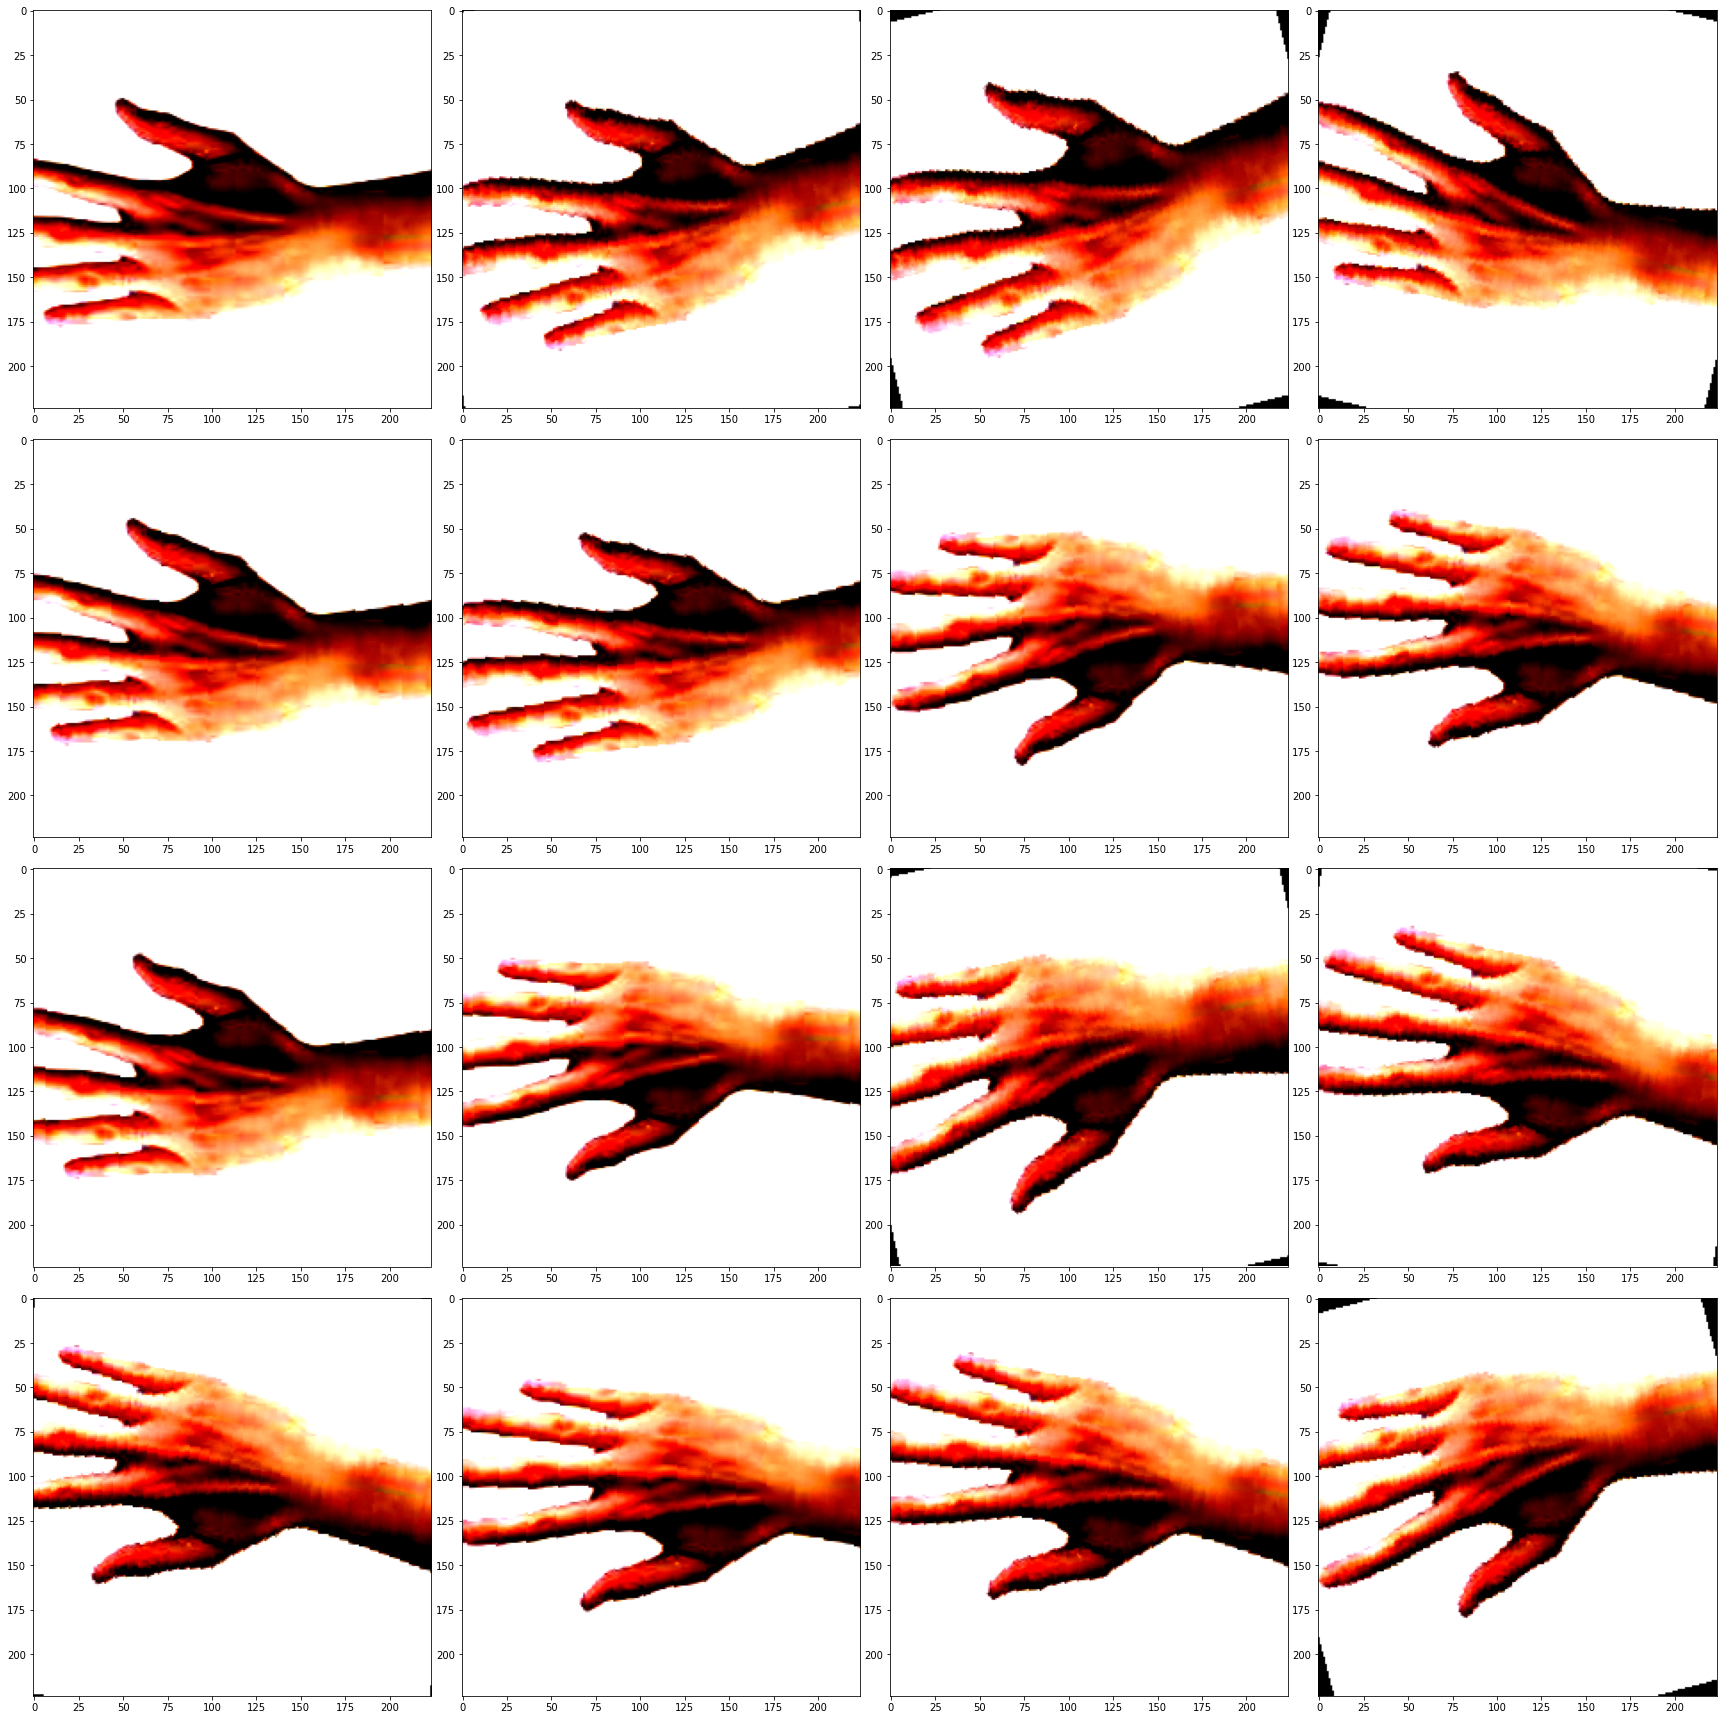

In [ ]:
ex_img = Image.open(test_img)
t = image_transforms['train']

plt.figure(figsize=(24, 24))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)

    plt.imshow(t(ex_img).T)

    #imshow_tensor(t(ex_img), ax=ax)
plt.tight_layout()

# RDM computation

## fMRI RDMs

Matrix to vector transformation

Shape of RDM is num_subjects x num_sessions x num_timepoints x num_stimulus x num_stimulus

### Loading RDMs in IT and EVR

In [33]:
fMRI_file = '92_Image_Set/target_fmri.mat'  # path of fMRI RDM file
fMRI_RDMs = loadmat(fMRI_file)  # load the fMRI RDMs
print(fMRI_RDMs.keys())
print(fMRI_RDMs['EVC_RDMs'].shape)

dict_keys(['EVC_RDMs', 'IT_RDMs'])
(15, 92, 92)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:46: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



In [34]:
# Get individual RMD for fMRI data using index [0, 15]
ind_RDM = fMRI_RDMs['EVC_RDMs'][14].shape
print(ind_RDM)

(92, 92)


fMRI_RDMs is a dictionary with keys 'EVC_RDMs' and 'IT_RDMs' corresponding to ROIs EVC and IT respectively. The shape of each RDM is num_subjects x num_stimulus x num_stimulus

Text(0, 0.5, '1-Correlation')

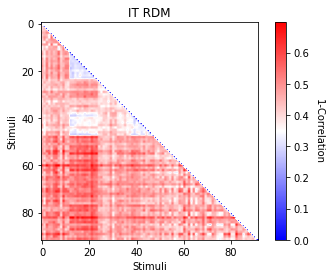

In [35]:
#@title visualize subject averaged fMRI RDMs
ROI = 'IT' #@param ["EVC", "IT"]

# Average the ROI RDM across subjects 
RDM_fmri_it = np.array(fMRI_RDMs[ROI + '_RDMs'].mean(axis=0))

# Since the matrix is symmetric we set upper triangular values to NaN
RDM_fmri_it[np.triu_indices(RDM_fmri_it.shape[0], 1)] = np.nan

# plot the ROI RDM at given timepoint for IT 
plt.imshow(RDM_fmri_it,\
           cmap="bwr")
plt.title(ROI + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('1-Correlation', rotation=270)


Text(0, 0.5, '1-Correlation')

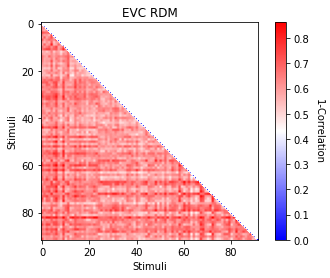

In [36]:
#@title visualize subject averaged fMRI RDMs
ROI = 'EVC' #@param ["EVC", "IT"]

# Average the ROI RDM across subjects 
RDM_fmri_evc = np.array(fMRI_RDMs[ROI + '_RDMs'].mean(axis=0))

# Since the matrix is symmetric we set upper triangular values to NaN
RDM_fmri_evc[np.triu_indices(RDM_fmri_evc.shape[0], 1)] = np.nan

# plot the ROI RDM at given timepoint for IT 
plt.imshow(RDM_fmri_evc,\
           cmap="bwr")
plt.title(ROI + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('1-Correlation', rotation=270)

## Behavioral Data RDMs

In [37]:
def compute_distance(image_label1, image_label2, dataframe, distance_metric = "correlation"):
    """
    Compute distance metrics accross individuals for a given a pair of image
    """
    # replace nan values by 3 (neutral)
    dataframe.rating = dataframe.rating.replace(np.nan, 3)

    # keep rows for image of interest 1
    df_1 = dataframe.loc[dataframe.image == image_label1]
    #print(df_1)

    # keep rows for image of interest 2
    df_2 = dataframe.loc[dataframe.image == image_label2]
    print(df_2)

    #df_2 = df_2.rename(columns = {"rating" : "rating1"})
    #print(df_2)
    
    # initialize distance metric
    distance = 0
    rating_1 = df_1.rating.astype(float).reset_index()
    rating_2 = df_2.rating.astype(float).reset_index()
    
    # merge
    df_distance = pd.concat([rating_1, rating_2], axis = 1)
    df_distance = df_distance[["rating"]]

    #print(df_distance)

    if distance_metric == "correlation":
        distance = df_distance.corr(method = "pearson")

        distance = distance.values[0][1]
    
    if distance_metric == "cosine_similarity":
        distance = cosine_similarity(np.array(df_2.rating).reshape(-1, 1), np.array(df_1.rating).reshape(-1, 1))
        
        # compute mean of all distances
        distance = distance.mean()

    elif distance_metric == "euclidean" :
        distance = euclidean_distances(np.array(df_2.rating).reshape(-1, 1), np.array(df_1.rating).reshape(-1, 1))
        distance = distance.mean()

        #normalize distance [-4, 4]

    return distance #rating_1, rating_2

# test distance function correlation outputs 0.37 ; euclidean 0.67
# distance = compute_distance("image_01", "image_02", df_sent, distance_metric = "correlation")


### Sentiment

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from scipy import stats

list_to_10 = ["image_0{}".format(i) for i in range(1, 10)]
list_10_to_92 = ["image_{}".format(i) for i in range(10, 93)]

list_images = np.concatenate([list_to_10, list_10_to_92])

def compute_distance_img_distribution(img_label1, img_label2, dataframe):
    """
    Compute mean and std deviation of distributions for img_label1 and img_label2
    Compare distribution of ratings for the pair of images
    Test for significant difference between 2 related variables (images)
    Nb. scores are not-independant, paired sample t-test is required.
    """

    # replace nan values by 3 (neutral)
    dataframe = dataframe.fillna(dataframe.mean())

    # keep rows for image of interest 1
    df_1 = dataframe.loc[dataframe.image == img_label1]
    #print(df_1)

    # keep rows for image of interest 2
    df_2 = dataframe.loc[dataframe.image == img_label2]
    #print(df_2)
    
    # initialize distance metric
    distance = 0

    # get data for img 1 and img 2
    rating_1 = df_1.rating.astype(float)
    rating_2 = df_2.rating.astype(float)

    # compute mean of the distribution
    mean_img1 = rating_1.mean()
    mean_img2 = rating_2.mean()

    # compute std of the distribution
    std_img1 = rating_1.std()
    std_img2 = rating_2.std()

    # compute t-test : is it likely that the mean from dist 2 comes from dist 1
    t_test = stats.ttest_rel(rating_1, rating_2)

    return t_test[0], t_test[1], mean_img1, mean_img2, std_img1, std_img2, rating_1, rating_2


def build_RDM(dataframe, list_images):

    # for all possible pairs of images 
    # compute the distance with previous function 
    
    # initialize empty RDM matrix
    RDM = np.zeros((92,92))
    
    # iterate over images
    for image_label1,a in zip(list_images, range(92)) :
        for image_label2,b in zip(list_images, range(92)) :

            #print(a, b)
            
            # across distributions 
            
            distance, p_value, _, _, _, _, _, _ = compute_distance_img_distribution(image_label1, image_label2, dataframe)
            
        
            # add istance to RDM 
            RDM[a][b] = distance

    return RDM

In [39]:
#print(list_images)

In [40]:
# plot example of distance calculation
# for the purpose of the example, we will compute the distance 
# between the distribution of image_05 and image_07

t_value, p_value, mean_img1, mean_img2, std_img1, std_img2, rating1, rating2 = compute_distance_img_distribution("image_05", "image_07", df_sent)

In [41]:
print("p value : {} , t_value : {}".format(p_value, t_value))

p value : 0.0340145659316915 , t_value : -2.214805006001719


In [42]:
# plot 
import plotly.figure_factory as ff

# Add histogram data
x1 = rating1
x2 = rating2

# Group data together
hist_data = [x1, x2]

group_labels = ['Image 06', 'Image 07']

# Create distplot with custom bin_size
#colors = ['#835AF1', '#7FA6EE', '#B8F7D4']
colors = ['#2327FF', '#FFFF23', '#FF2327' ]
fig = ff.create_distplot(hist_data, group_labels, bin_size=1, show_curve=False, colors = colors)

# add mean for image 06
fig.add_shape(type="line",x0=mean_img1, x1=mean_img1, y0 =0, y1=1 , xref='x', yref='y',
               line = dict(color = colors[0], dash = 'dash'))

# add mean for image 07
fig.add_shape(type="line",x0=mean_img2, x1=mean_img2, y0 =0, y1=1 , xref='x', yref='y',
               line = dict(color = colors[1], dash = 'dash'))

# add title
fig.update_layout(title_text='Distribution for sentiment scores from two images in the dataset')

fig.show()

In [ ]:
# Computing RDM for 92 images using t-value as distance metric
#(this chunk takes more than 2 min to run. you can load the saved RDMs from the folder using the following coee)
#RDM_sentiment = build_RDM(df_sent, list_images)
#RDM = np.zeros((92,92))
#np.save("/work/RDMs/RDM_sentiment.npy", RDM_sentiment)

In [43]:
# load npy without re-running cells above
RDM_sent = np.load("/work/RDMs/RDM_sentiment.npy")

Text(80, 119, 'Artificial')

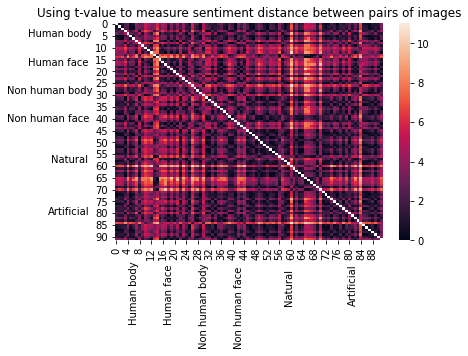

In [44]:
import seaborn as sns
ax = plt.axes()

# We need to use absolute values (img-7, img-5 = 2 ; img-5, img-7 = -2)
ax.set_title('Using t-value to measure sentiment distance between pairs of images')

sns.heatmap(np.absolute(RDM_sent), annot=False, ax=ax)

ax.annotate('Human body', xy=(-5, 0),xytext=(-30,6),                     #draws an arrow from one set of coordinates to the other
            annotation_clip=False)                               #This enables the arrow to be outside of the plot

ax.annotate('Human face',xy=(0,12),xytext=(-30,18),          
            annotation_clip=False)

ax.annotate('Non human body',xy=(0,24),xytext=(-37,30),             
            annotation_clip=False)

ax.annotate('Non human face',xy=(0,36),xytext=(-37,42),              
            annotation_clip=False)

ax.annotate('Natural',xy=(0,48),xytext=(-22,59),              
            annotation_clip=False)

ax.annotate('Artificial',xy=(0,70),xytext=(-23,81),              
            annotation_clip=False)

ax.annotate('Human body',xy=(0,120),xytext=(5,127), rotation = 90,             
            annotation_clip=False)

ax.annotate('Human face',xy=(0,120),xytext=(17,127), rotation = 90,             
            annotation_clip=False)

ax.annotate('Non human body',xy=(0,120),xytext=(29,137), rotation = 90,             
            annotation_clip=False)

ax.annotate('Non human face',xy=(0,120),xytext=(41,137), rotation = 90,             
            annotation_clip=False)

ax.annotate('Natural',xy=(0,120),xytext=(58,119), rotation = 90,             
            annotation_clip=False)

ax.annotate('Artificial',xy=(0,120),xytext=(80,119), rotation = 90,             
            annotation_clip=False)


The **t-value** measures the size of the difference relative to the variation in your sample data. Put another way, T is simply the calculated difference represented in units of standard error. The greater the magnitude of T, the greater the evidence against the null hypothesis.

### Familiarity 

In [ ]:
# Computing RDM for 92 images using t-value as distance metric (this chunk takes more than 2 min to run. you can load the saved RDMs from the folder using the following coee)
#RDM_fam = build_RDM(df_familiarity, list_images)
#np.save("/work/RDMs/RDM_familiarity.npy", RDM_fam)

In [45]:
#load the rdm for familiarity 
RDM_fam = np.load("/work/RDMs/RDM_familiarity.npy")

Text(80, 119, 'Artificial')

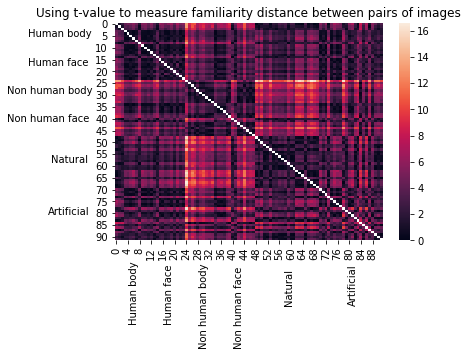

In [46]:
ax = plt.axes()

# We need to use absolute values (img-7, img-5 = 2 ; img-5, img-7 = -2)
sns.heatmap(np.absolute(RDM_fam), annot=False, ax=ax)

ax.set_title('Using t-value to measure familiarity distance between pairs of images')
ax.annotate('Human body', xy=(-5, 0),xytext=(-30,6),                     #draws an arrow from one set of coordinates to the other
            annotation_clip=False)                               #This enables the arrow to be outside of the plot

ax.annotate('Human face',xy=(0,12),xytext=(-30,18),          
            annotation_clip=False)

ax.annotate('Non human body',xy=(0,24),xytext=(-37,30),             
            annotation_clip=False)

ax.annotate('Non human face',xy=(0,36),xytext=(-37,42),              
            annotation_clip=False)

ax.annotate('Natural',xy=(0,48),xytext=(-22,59),              
            annotation_clip=False)

ax.annotate('Artificial',xy=(0,70),xytext=(-23,81),              
            annotation_clip=False)

ax.annotate('Human body',xy=(0,120),xytext=(5,127), rotation = 90,             
            annotation_clip=False)

ax.annotate('Human face',xy=(0,120),xytext=(17,127), rotation = 90,             
            annotation_clip=False)

ax.annotate('Non human body',xy=(0,120),xytext=(29,137), rotation = 90,             
            annotation_clip=False)

ax.annotate('Non human face',xy=(0,120),xytext=(41,137), rotation = 90,             
            annotation_clip=False)

ax.annotate('Natural',xy=(0,120),xytext=(58,119), rotation = 90,             
            annotation_clip=False)

ax.annotate('Artificial',xy=(0,120),xytext=(80,119), rotation = 90,             
            annotation_clip=False)

## Visual Attribute RDMs 

### Creating DNN (AlexNet) RDMs

In [53]:
#@title AlexNet Definition
__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

# Here we redefine AlexNet differently from torchvision code for better understanding
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Sequential(   
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2), #3 input channels and 64 output channels, stride sampling through every 4 pixels
            nn.ReLU(inplace=True), #activation function/non-linearity 
            nn.MaxPool2d(kernel_size=3, stride=2), #take the maximum value of the window 
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            )
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            )
        self.fc6 = nn.Sequential( # fully connected layers; no explicity spatial representations
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            )
        self.fc7 =nn.Sequential(
            nn.Dropout(),
            nn.Linear(4096, 4096),
            )
        self.fc8 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            )
           
           

    def forward(self, x): #defines the flow of the information 
        out1 = self.conv1(x)  #will be the output of nn.MaxPool2d(kernel_size=3, stride=2)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        out4 = self.conv4(out3)
        out5 = self.conv5(out4)

        out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
        out6= self.fc6(out5_reshaped)
        out7= self.fc7(out6)
        out8 = self.fc8(out7)

        return out1, out2, out3, out4, out5, out6, out7, out8


def alexnet(pretrained=False, **kwargs):
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = AlexNet(**kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['alexnet']))
    return model 

In [58]:
#@title Feature extraction code
# !pip install ipdb


def load_alexnet(model_checkpoints, softmax = False):
    """This function initializes an Alexnet and load
    its weights from a pretrained model. Since we redefined model in a different
    way we have to rename the weights that were in the pretrained checkpoint ().
    ----------
    model_checkpoints : str
        model checkpoints location.
    Returns
    -------
    model
        pytorch model of alexnet
    """

    model = alexnet()

    if softmax == True:
        model= model = nn.Sequential(model, nn.Softmax(1))

    # Load checkpoint
    model_file = model_checkpoints
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)

    # Rename the checkpoint keys according to new definition
    ## we want to look at conv1.0.weight , not bias 
    if softmax == False:
        model_dict =["conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias", "conv3.0.weight", "conv3.0.bias", "conv4.0.weight", "conv4.0.bias", "conv5.0.weight", "conv5.0.bias", "fc6.1.weight", "fc6.1.bias", "fc7.1.weight", "fc7.1.bias", "fc8.1.weight", "fc8.1.bias"]
    
    else :
        model_dict = ["0.conv1.0.weight", "0.conv1.0.bias", "0.conv2.0.weight", "0.conv2.0.bias", "0.conv3.0.weight", "0.conv3.0.bias", "0.conv4.0.weight", "0.conv4.0.bias", "0.conv5.0.weight", "0.conv5.0.bias", "0.fc6.1.weight", "0.fc6.1.bias", "0.fc7.1.weight", "0.fc7.1.bias", "0.fc8.1.weight", "0.fc8.1.bias"]
   
    state_dict={}
    i=0
    for k,v in checkpoint.items():
        state_dict[model_dict[i]] =  v
        i+=1

    # initialize model with pretrained weights 
    model.load_state_dict(state_dict)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model


def get_activations_and_save(model, image_list, activations_dir):
    """This function generates Alexnet features and save them in a specified directory.
    Parameters
    ----------
    model :
        pytorch model : alexnet.
    image_list : list
        the list contains path to all images.
    activations_dir : str
        save path for extracted features.
    """
    # alexnet was trained on 224,224, we need to reshape our images
    resize_normalize = trn.Compose([
            trn.Resize((224,224)),
            trn.ToTensor(),
            trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # for all images in the list generate and save activations
    for image_file in tqdm(image_list):
        
        # open image
        img = Image.open(image_file)
        image_file_name = os.path.split(image_file)[-1].split(".")[0]

        # apply transformations before feeding to model
        input_img = V(resize_normalize(img).unsqueeze(0))
        if torch.cuda.is_available():
            input_img=input_img.cuda()
        x = model.forward(input_img)

        activations = []
        for i,feat in enumerate(x):
            activations.append(feat.data.cpu().numpy().ravel())

        for layer in range(len(activations)):
            save_path = os.path.join(activations_dir, image_file_name+"_"+"layer" + "_" + str(layer+1) + ".npy")
            np.save(save_path,activations[layer])


In [60]:
# softmax added
model

Sequential(
  (0): AlexNet(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv4): Sequential(
      (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (conv5): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc6): Seque

In [62]:
# get the paths to all the images in the stimulus set
image_dir = '92_Image_Set/92images'
image_list = glob.glob(image_dir + '/*.jpg')
image_list.sort()
print('Total Number of Images: ', len(image_list))
save_dir = "/work/VisualAttribute_DNN/activations_alexnet/"

######### load Alexnet initialized with pretrained weights ###################
# Download pretrained Alexnet from:
# https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth
# and save in the current directory
checkpoint_path = "/work/VisualAttribute_DNN/alexnet.pth"
if not os.path.exists(checkpoint_path):
    url = "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
    urllib.request.urlretrieve(url, "/work/VisualAttribute_DNN/alexnet.pth")
model = load_alexnet(checkpoint_path, softmax = False)

##############################################################################

######### get and save activations ################################

activations_dir = os.path.join(save_dir)
if not os.path.exists(activations_dir):
    os.makedirs(activations_dir)
print("-------------Saving activations ----------------------------")
get_activations_and_save(model, image_list, activations_dir)
###################################################################

Total Number of Images:  92
-------------Saving activations ----------------------------
100%|██████████| 92/92 [00:09<00:00,  9.72it/s]


In [ ]:
num_layers = 8  # number of layers in the model (we only need the first layer, but we will keep the loop intact)
layers = []

for i in range(num_layers):
  layers.append("layer" + "_" + str(i+1))

model_RDMs = {}

# create RDM for each layer from activations
for layer in layers:
  activation_files =  glob.glob(activations_dir + '/*'+layer + '.npy')
  activation_files.sort()
  activations = []
  # Load all activations
  for activation_file  in activation_files:
    activations.append(np.load(activation_file))
  activations = np.array(activations)

  # calculate Pearson's distance for all pairwise comparisons 
  model_RDMs[layer] = 1-np.corrcoef(activations)

### Plotting RDMs of all 8 layers 

In [ ]:
print(model.conv1[0].weight.shape)

weigths_f1 = model.conv1[0].weight

# replace  by the good values
#weigths = model.conv1.weight.detach() 

#weights = convLayer.conv.weight.detach()

# plot as images by reshaping 

torch.Size([64, 3, 11, 11])


64 output channels and 3 input channels and the kernel size is 11*11

0 0 1
1 0 2


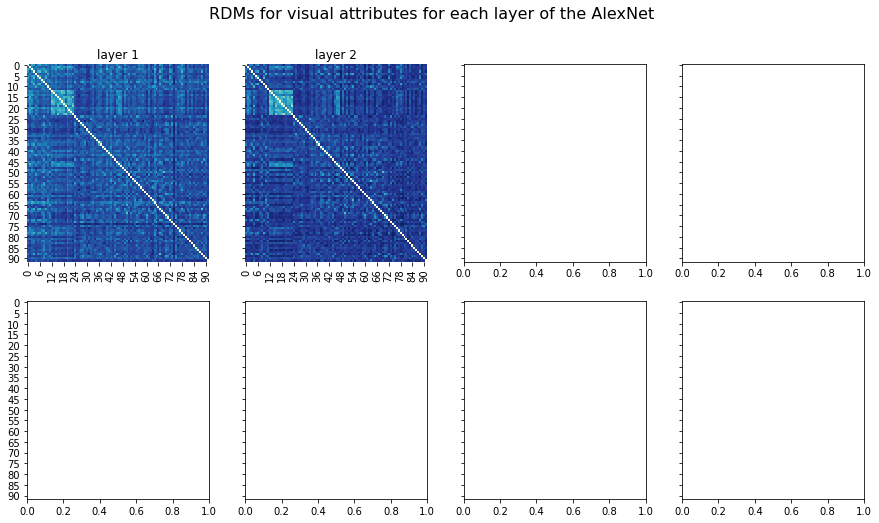

In [70]:
# import RDM fMRI without re-running the cells and plot layers

path_rdm_layer = "/work/RDMs/RDM_layer_{}.npy"

# create subplots 
f, axes = plt.subplots(2,4,sharey=True, figsize=(15,8))

row = 0
col = 0

for i, ax in zip(range(1, 9), axes):

    # load RDM as np array
    RDM = np.load(path_rdm_layer.format(i))

    print(col, row, i)

    # plot layer RDM
    g1 = sns.heatmap(RDM,cmap="YlGnBu",cbar=False,ax = axes[row, col])

    # set subtitle
    axes[row, col].set_title("layer {}".format(i))

    # update row and col value for plot axs
    if i == 4:
        
        # set row to 1
        row = 1

        # reset column and i 
        col = 0
        i = 1
    
    else:
        col += 1

# save figure
f.suptitle("RDMs for visual attributes for each layer of the AlexNet", fontsize=16)
plt.savefig("/work/Figures/Figures.png")

In [ ]:
#save the Alexnet layer RDM 
layers = ['layer_{}'.format(i) for i in range(9)]

for layer in layers:
    # loading layer RDM
    RDM = np.array(model_RDMs[layer])
    np.save("/work/RDMs/RDM_{}.npy".format(layer), RDM)

KeyError: 'layer_0'

### Computing white pixel % (pending)

# Analysis

The goal of the following analysis was to determine the contributions of subjective perceptual features (sentiment, familiarity/novelty),&nbsp;DNN and&nbsp;object feature models to neural representations in IT cortex.

## Correlation

In [71]:
# Compute RDM correlations between various attributes (behavioral, visual and fMRI)
# Plot correlations

In [73]:
# Behavorial RDMs
RDM_sent = np.abs(RDM_sent)
RDM_fam = np.abs(RDM_fam)

# Visual attributes RDMs
RDM_layer1= np.load(path_rdm_layer.format(1))
RDM_layer2= np.load(path_rdm_layer.format(2))
RDM_layer3= np.load(path_rdm_layer.format(3))
RDM_layer4= np.load(path_rdm_layer.format(4))
RDM_layer5= np.load(path_rdm_layer.format(5))
RDM_layer6= np.load(path_rdm_layer.format(6))
RDM_layer7= np.load(path_rdm_layer.format(7))
RDM_layer8= np.load(path_rdm_layer.format(8))

# fMRI RDMS
RDM_fmri_evc # early visual cortex
RDM_fmri_it # infero-temporal 

array([[0.        ,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.43813209, 0.        ,        nan, ...,        nan,        nan,
               nan],
       [0.39572224, 0.44306233, 0.        , ...,        nan,        nan,
               nan],
       ...,
       [0.57933811, 0.464373  , 0.61545736, ..., 0.        ,        nan,
               nan],
       [0.4804096 , 0.39372626, 0.53491923, ..., 0.3921473 , 0.        ,
               nan],
       [0.50420761, 0.43423467, 0.5211363 , ..., 0.44002391, 0.36521237,
        0.        ]])

In [75]:
# create array containing all RDMs 
RDMS = [RDM_sent, RDM_fam, RDM_layer1, RDM_layer2, RDM_layer3, RDM_layer4, RDM_layer5, RDM_layer6, RDM_layer7, RDM_layer8, RDM_fmri_it, RDM_fmri_evc]

In [76]:
#@title Correlating fMRI RDMs with sentiment RDMs
# helper functions
from scipy.stats import spearmanr

def RSA_spearman(rdm1,rdm2):
    """
    computes and returns the spearman correlation between lower triangular 
    part of the input rdms. We only need to compare either lower or upper 
    triangular part of the matrix as RDM is symmetric
    """
    # get lower triangular part of the RDM1 
    lt_rdm1 = get_lowertriangular(rdm1)
    # get lower triangular part of the RDM1 
    lt_rdm2 = get_lowertriangular(rdm2)
    # return Spearman's correlation between lower triangular part of rdm1 & rdm2
    return spearmanr(lt_rdm1, lt_rdm2)[0]

def get_lowertriangular(rdm):
    """
    returns lower triangular part of the matrix
    """
    num_conditions = rdm.shape[0]
    return rdm[np.tril_indices(num_conditions,-1)]

In [77]:
# compute pairwise spearman rank correlation: how similar are these RDMS between different attributes?

#initialize empty similarity matrix
similarity_rdm = np.zeros((12,12))

for RDM_attribute1, a in zip(RDMS, range(13)):
    for RDM_attribute2, b in zip(RDMS, range(13)):
        correlation_spearm = RSA_spearman(RDM_attribute1,RDM_attribute2)

        # fill matrix
        similarity_rdm[a][b] = correlation_spearm

<AxesSubplot:>

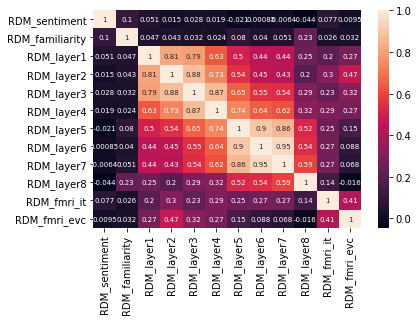

In [78]:
RDM_labels = ["RDM_sentiment", "RDM_familiarity", "RDM_layer1", "RDM_layer2", "RDM_layer3", "RDM_layer4", "RDM_layer5", "RDM_layer6", "RDM_layer7", "RDM_layer8", "RDM_fmri_it", "RDM_fmri_evc"]
x_axis_labels = RDM_labels # labels for x-axis
y_axis_labels = RDM_labels # labels for y-axis
sns.heatmap(similarity_rdm, annot=True, annot_kws={"size": 7}, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

[significance tests are required to test the correlations]: The correlation graph above shows that image familiarity is highly correlated with DNN_layer8. IT regions are reasonably correlated with higher-level DNN layers. And consistent with Cichy et al., 2014, EVC regions are generally correlated with lower-level DNN layers. We didn't find sentiment to be in correlation with any other measures. 

In [79]:
# plt RMDs correlation for both regions of interest
import pandas as pd

EVC_labels = pd.DataFrame(np.array(["EVC" for i in range(10)])).rename(columns = {0: "label"})
IT_labels = pd.DataFrame(np.array(["IT" for i in range(10)])).rename(columns = {0: "label"})

RDM_labels = pd.DataFrame(RDM_labels).rename(columns = {0: "attribute"})

EVC_corr = pd.DataFrame(similarity_rdm[11, :]).rename(columns = {0: "spearm"}) # all correlations for EVC
IT_corr = pd.DataFrame(similarity_rdm[10, :]).rename(columns = {0: "spearm"}) # all correlations for IT

In [80]:
corr_df_evc= pd.concat([EVC_corr,EVC_labels, RDM_labels], axis = 1)
corr_df_it = pd.concat([IT_corr,IT_labels, RDM_labels], axis = 1)

In [81]:
corr_df = pd.concat([corr_df_it, corr_df_evc])

In [133]:
vec_sent

NameError: name 'vec_sent' is not defined

In [89]:
corr_df

,spearm,label,attribute
0,0.076557,IT,RDM_sentiment
1,0.025736,IT,RDM_familiarity
2,0.204991,IT,RDM_layer1
3,0.304221,IT,RDM_layer2
4,0.228745,IT,RDM_layer3
5,0.290423,IT,RDM_layer4
6,0.250695,IT,RDM_layer5
7,0.265665,IT,RDM_layer6
8,0.265535,IT,RDM_layer7
9,0.137832,IT,RDM_layer8


In [98]:
corr_to_plot = corr_df.loc[((corr_df.attribute != "RDM_fmri_evc") & (corr_df.attribute != "RDM_fmri_it"))]

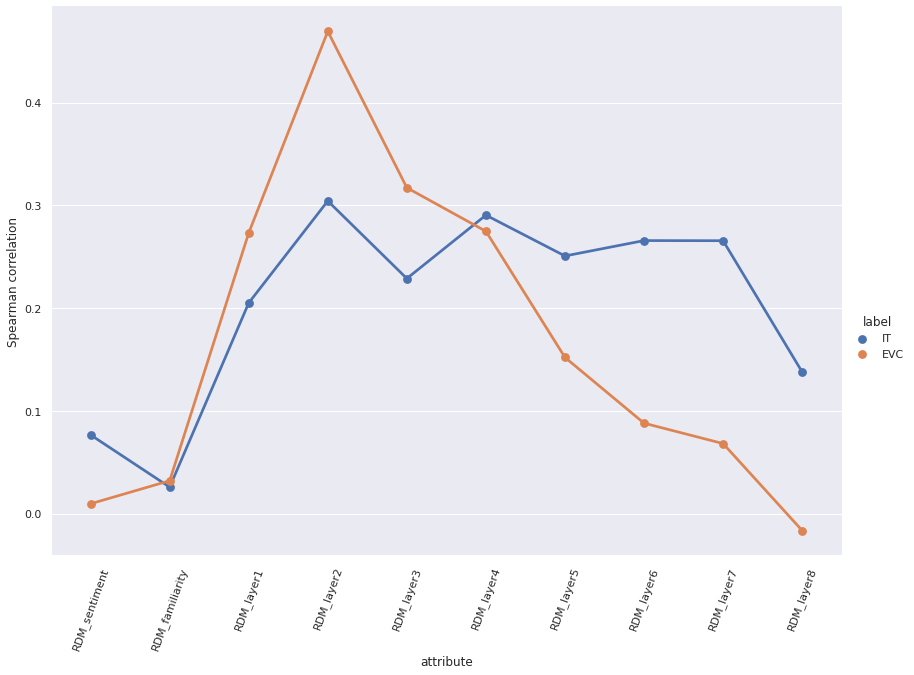

In [100]:
sns.set_theme()
spearm_corr = sns.catplot(x="attribute", y="spearm", hue ="label", kind="point", data=corr_to_plot, height=8.27, aspect=11.7/8.27)
plt.xticks(rotation=70)
plt.ylabel("Spearman correlation")
# save
spearm_corr.savefig("/work/Figures/spearman_correlation_ROIs.png")

In [ ]:
#@title Correlating MEG RDMs with DNN RDMs

num_timepoints = MEG_RDM_sub_averaged.shape[0]#get number of timepoints

# initialize a dictionary to store MEG and DNN RDM correlation at each timepoint
for layer in layers:
  MEG_correlation[layer] = []

# for loop that goes over MEG RDMs at all time points and correlate with DNN RDMs
for t in range(num_timepoints):
  MEG_RDM_t = MEG_RDM_sub_averaged[t,:,:]
  for layer in layers:
    model_RDM = model_RDMs[layer]
    MEG_correlation[layer].append(RSA_spearman(model_RDM,MEG_RDM_t))

In [ ]:
!wget -qO 92_Image_Set/cichy_stim_details.mat -c http://wednesday.csail.mit.edu/MEG1_MEG_Clear_Data/visual_stimuli.mat
def get_stim_details(path_to_file='92_Image_Set/cichy_stim_details.mat'):
  """
  acquire category names and binary features describing the Cichy images

  returns: stim_details (dict containing 5 keys: category (str), and four binary features (animate, human, natural, face)). 
                          each key holds an array giving the information for all categories
  """
  stim_dat = loadmat(path_to_file)['visual_stimuli']
  fields = ['category', 'animate', 'human', 'natural', 'face']
  stim_details = {field:[] for field in fields}
  for ii in range(92):
    for jj, field in enumerate(fields):
      stim_details[field].append(stim_dat[0,ii][jj][0])
  for field in fields[1:]:
    stim_details[field] = np.array(stim_details[field]).squeeze()
  return stim_details

get_stim_details()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:46: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



{'category': ['human bodypart',
  'human bodypart',
  'human bodypart',
  'human bodypart',
  'human bodypart',
  'human bodypart',
  'human bodypart',
  'human bodypart',
  'human bodypart',
  'human bodypart',
  'human bodypart',
  'human bodypart',
  'human face',
  'human face',
  'human face',
  'human face',
  'human face',
  'human face',
  'human face',
  'human face',
  'human face',
  'human face',
  'human face',
  'human face',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman bodypart',
  'nonhuman face',
  'nonhuman face',
  'nonhuman face',
  'nonhuman face',
  'nonhuman face',
  'nonhuman face',
  'nonhuman face',
  'nonhuman face',
  'nonhuman face',
  'nonhuman face',
  'nonhuman face',
  'nonhuman face',
  'natural inanimate',
  'natural inanimate',
  'nat

## Regression

In [101]:
import pandas as pd
from sklearn import linear_model
#import tkinter as tk 
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

In [102]:

RDM_U = [i for i in range(12)]
RDM_labels = ["vec_sentiment", "vec_fam", "vec_layer1", "vec_layer2", "vec_layer3", "vec_layer4", "vec_layer5", "vec_layer6", "vec_layer7", "vec_layer8", "vec_fmri_it", "vec_fmri_evc"]

d = {}

for RDM, i in zip(RDMS, range(len(RDMS))):
    RDM_half = get_lowertriangular(RDM)

    d[RDM_labels[i]] = RDM_half

In [139]:
#make the list a dataframe 
df = pd.DataFrame(d)


SyntaxError: invalid character in identifier (364771784.py, line 2)

In [142]:
df.corr(method='spearman')

,vec_sentiment,vec_fam,vec_layer1,vec_layer2,vec_layer3,vec_layer4,vec_layer5,vec_layer6,vec_layer7,vec_layer8,vec_fmri_it,vec_fmri_evc
vec_sentiment,1.000000,0.100079,0.050635,0.014544,0.027626,0.018852,-0.021258,0.000849,-0.006395,-0.044078,0.076557,0.009537
vec_fam,0.100079,1.000000,0.047258,0.043248,0.031721,0.023881,0.079596,0.040013,0.050906,0.229671,0.025736,0.031969
vec_layer1,0.050635,0.047258,1.000000,0.814021,0.793936,0.633132,0.501892,0.439007,0.442771,0.248033,0.204991,0.273111
vec_layer2,0.014544,0.043248,0.814021,1.000000,0.876924,0.733331,0.543572,0.446911,0.425824,0.198898,0.304221,0.469321
vec_layer3,0.027626,0.031721,0.793936,0.876924,1.000000,0.868085,0.649688,0.548910,0.537498,0.292268,0.228745,0.317097
vec_layer4,0.018852,0.023881,0.633132,0.733331,0.868085,1.000000,0.737568,0.644795,0.617012,0.316320,0.290423,0.274699
vec_layer5,-0.021258,0.079596,0.501892,0.543572,0.649688,0.737568,1.000000,0.898560,0.859940,0.519086,0.250695,0.151969
vec_layer6,0.000849,0.040013,0.439007,0.446911,0.548910,0.644795,0.898560,1.000000,0.950469,0.537687,0.265665,0.087956
vec_layer7,-0.006395,0.050906,0.442771,0.425824,0.537498,0.617012,0.859940,0.950469,1.000000,0.591614,0.265535,0.068126
vec_layer8,-0.044078,0.229671,0.248033,0.198898,0.292268,0.316320,0.519086,0.537687,0.591614,1.000000,0.137832,-0.016482


In [104]:
np.save("/work/RDMs/df.npy",df)

In [105]:
# keep half matrix and transform into vector
def upper_tri_masking(A):
    """Keep upper portion of matrix and returns as vector
    args
    A : Matrix 

    returns
    Vector with half of values (no diagonal)
    """

    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] <r

    return A[mask]

In [135]:
vec_layer2

NameError: name 'vec_layer2' is not defined

In [108]:
# @ helper functions for regression 
# sklearn

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def Regression(df, X_variables, y_variable, standardize = True):
    '''
    Args
    X : ["vec_sentiment", "vec_layer2"]
    y : ["vec_it"]
    
    returns
    r2 
    coef 
    ''' 
    
    y = df[y_variable].astype(float)
    X = df[X_variables].astype(float)
   
    # standardize dataframe. nb. if we are working with correlations, then it is already bet 0-1
    if standardize == True:
        y = y.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)
        X = X.select_dtypes(include=[np.number]).dropna().apply(stats.zscore)
    
     
    # load model
    regr = linear_model.LinearRegression()
    
    # fit data
    regr.fit(X, y)
    
    # predict y hat
    y_hat = regr.predict(X)
    
    # The mean squared error
    mse = mean_squared_error(y, y_hat)
    
    # The coefficient of determination (explained variance): 1 is perfect prediction
    r2 = r2_score(y, y_hat)
    
    # estimators 
    coef = regr.coef_
        
    return coef, r2,mse

def describe_result(coef, r2, summary, mse):
    """Describe result from regression"""

    print("----------------STATISTICS------------------")
    print("beta coefficient{}".format(coef))

    return


def plot_regression(X, y, y_hat):
    """Plot outputs from regression"""
    
    # Plot outputs
    plt.scatter(X, y,  color='black')
    plt.plot(X, y_hat, color='blue', linewidth=3)
    
    plt.xticks(())
    plt.yticks(())
    
    plt.show()

### Predicting IT regions 

Mod1 is the full model that contains both behavioral variables sentiment, familiarity and DNN layer 2 and layer 7. 

In [145]:
coef_mod1, r2_mod1, mse_mod1 = Regression(df, ["vec_sentiment", "vec_fam", "vec_layer2", "vec_layer7"], ["vec_fmri_evc"], standardize = True)

In [136]:
df.vec_sentiment

0       0.626961
1       1.100389
2       0.226093
3       1.867918
4       2.666667
          ...   
4181    4.142706
4182    3.871471
4183    2.526456
4184    3.499879
4185    3.676580
Name: vec_sentiment, Length: 4186, dtype: float64

In [144]:
coef_mod1, r2_mod1, mse_mod1 = Regression(df, ["vec_fam", "vec_layer7"] , ["vec_fmri_evc"], standardize = True)

In [146]:
print("R2 from model : {}".format(r2_mod1))
print("coefficient (variance explained by each attribute) : {}".format(coef_mod1))
print("MSE: {}".format(mse_mod1))

R2 from model : 0.22134247670004314
coefficient (variance explained by each attribute) : [[ 0.00089755  0.00193151  0.54735622 -0.19002898]]
MSE: 0.7786575232999569


So our total model explains 22.1% variance in the neural representation in IT region

Mod2 contains all variables but vec_sentiment 

In [111]:
coef_mod2, r2_mod2, mse_mod2 = Regression(df, ["vec_fam", "vec_layer2", "vec_layer7"], ["vec_fmri_it"], standardize = True)
print("R2 from model : {}".format(r2_mod2))
print("coefficient (variance explained by each attribute) : {}".format(coef_mod2))
print("MSE: {}".format(mse_mod2))
sent_unique = r2_mod1 - r2_mod2
print("unique contribution of sentiment is : {}".format(sent_unique))

R2 from model : 0.17436989381160917
coefficient (variance explained by each attribute) : [[-0.01500038  0.26933746  0.20482566]]
MSE: 0.8256301061883908
unique contribution of sentiment is : 0.04697258288843398


Mod3 contains all variables but vec_fam 

In [112]:
coef_mod3, r2_mod3, mse_mod3 = Regression(df, ["vec_sentiment", "vec_layer2", "vec_layer7"], ["vec_fmri_it"], standardize = True)
print("R2 from model : {}".format(r2_mod3))
print("coefficient (variance explained by each attribute) : {}".format(coef_mod3))
print("MSE: {}".format(mse_mod3))
fam_unique = r2_mod1 - r2_mod3
print("unique contribution of familiarity is : {}".format(fam_unique))

R2 from model : 0.18300605633635503
coefficient (variance explained by each attribute) : [[0.09414527 0.26644294 0.20510137]]
MSE: 0.816993943663645
unique contribution of familiarity is : 0.03833642036368812


Mod4 contains all variables but DNN layer 2

In [ ]:
coef_mod4, r2_mod4, mse_mod4 = Regression(df, ["vec_sentiment", "vec_fam", "vec_layer7"], ["vec_fmri_it"], standardize = True)
print("R2 from model : {}".format(r2_mod4))
print("coefficient (variance explained by each attribute) : {}".format(coef_mod4))
print("MSE: {}".format(mse_mod4))
DNN2_unique = r2_mod1 - r2_mod4
print("unique contribution of DNN_layer2 is : {}".format(DNN2_unique))

R2 from model : 0.15921378471896597
coefficient (variance explained by each attribute) : [[0.02203818 0.0312648  2.59560759]]
MSE: 0.840786215281034
unique contribution of DNN_layer2 is : 0.05293115862855946


Mod5 contains all variables but DNN layer 7

In [ ]:
coef_mod5, r2_mod5, mse_mod5 = Regression(df, ["vec_sentiment", "vec_fam", "vec_layer2"], ["vec_fmri_it"], standardize = True)
print("R2 from model : {}".format(r2_mod5))
print("coefficient (variance explained by each attribute) : {}".format(coef_mod5))
print("MSE: {}".format(mse_mod5))
DNN7_unique = r2_mod1 - r2_mod5
print("unique contribution of DNN_layer7 is : {}".format(DNN7_unique))

R2 from model : 0.18630908949495173
coefficient (variance explained by each attribute) : [[0.02580011 0.03231775 4.34790569]]
MSE: 0.8136909105050483
unique contribution of DNN_layer7 is : 0.025835853852573698


In [ ]:
#plot the euler diagram 
https://www.python-graph-gallery.com/venn-diagram/ 

### Predicting EVC regions (repete the same thing  

In [147]:
#we compute the unique contribution of vec_sentiment 
coef, r2, mse = Regression(df, ["vec_fam", "vec_layer1", "vec_layer2", "vec_layer3", "vec_layer4", "vec_layer5", "vec_layer6", "vec_layer7", "vec_layer8"], ["vec_fmri_it"], standardize = False)
print("R2 from model : {}".format(r2))
print("coefficient (variance explained by each attribute) : {}".format(coef))
print("MSE: {}".format(mse))

R2 from model : 0.22879819386768685
coefficient (variance explained by each attribute) : [[-3.16950179e-04 -1.28758973e-01  6.05351951e-01 -7.99314832e-01
   4.40698596e-01 -1.54419523e-01  5.42269446e-02  1.19764044e-01
   1.68129369e-03]]
MSE: 0.0037376611228691686


### 

## Variance Partitioning Analysis (Euler Diagram)

Euler diagram depicting results of variance partitioning the average dissimilarity in each ROI between models, expressed as percentages of unique and shared variance of the variance explained by all three models together.

# References 

1. Resolving human object recognition in space and time. Cichy et al. Nature Neuroscience 2014&nbsp;2.&nbsp;Representational similarity analysis – connecting the branches of systems neuroscience. Kriegeskorte et al. Front. Syst. Neurosci., 2008

2. Cichy, R., Khosla, A., Pantazis, D.&nbsp;et al.&nbsp;Comparison of deep neural networks to spatio-temporal cortical dynamics of human visual object recognition reveals hierarchical correspondence.&nbsp;Sci Rep&nbsp;6,&nbsp;27755 (2016). https://doi.org/10.1038/srep27755
 

3. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de32c980-084a-4931-9472-0473e37a94cf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>